In [2]:
import os
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import sys
# LIFE path
sys.path.append('./MultiScale')
sys.path.append('./MultiScale/core')
from skimage import io
from matplotlib import pyplot as plt
import cv2
import numpy as np
import torch
from flow_estimator import Flow_estimator
from config import get_demo_args, get_life_args, get_raft_args
from core.utils.utils import image_flow_warp
import configargparse

args = get_raft_args()
args.model = './model/MultiScale_latest.pth'
estimator = Flow_estimator(args)

In [3]:
def read_video(video_path, W=640, H=480):
    cap = cv2.VideoCapture(video_path)
    imgs = []
    plt.figure()
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            #frame = cv2.resize(frame, (W, H))
            imgs.append(frame)            
        else:
            break
    fps = cap.get(cv2.CAP_PROP_FPS)    
    cap.release()
    print(len(imgs))
    return imgs, fps

def save_video(imgs, size, video_path, fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_path, fourcc, fps, size)
    for frame in imgs:
        out.write(frame)
    out.release()
    print('video saved')
    

In [4]:
def blend(estimator, target, scene, source):
    H, W = 480, 640
    scn_ori_H, scn_ori_W = scene.shape[:2]
    src_ori_H, src_ori_W = source.shape[:2]
    zero = np.zeros_like(scene)
    
    if src_ori_H > src_ori_W:
        ratio = scn_ori_H / src_ori_H
        source = cv2.resize(source, None, fx=ratio, fy=ratio)
        src_H, src_W = source.shape[:2]
        start_x = int(scn_ori_W/2 - src_W/2)
        zero[0:src_H, start_x:start_x+src_W] = source
    
    else:
        ratio = scn_ori_W / src_ori_W
        source = cv2.resize(source, None, fx=ratio, fy=ratio)
        src_H, src_W = source.shape[:2]
        start_y = int(scn_ori_H/2 - src_H/2)
        zero[start_y:start_y+src_H, 0:src_W] = source
    source = zero 
    #plt.figure()
    #plt.imshow(source[:,:,::-1])
    
    
    
    target = cv2.resize(target, (W, H))
    scene = cv2.resize(scene, (W, H))
    source = cv2.resize(source, (W, H))
    '''
    flow = estimator.estimate(scene, target)conda
    out = image_flow_warp(target, flow[0].permute([1,2,0]))
    intensity = np.linalg.norm(out, axis=2)
    mask = (intensity == 0)[:,:,np.newaxis]  
    out = image_flow_warp(source, flow[0].permute([1,2,0]))     
    result = (out * (1 - mask) + scene * mask).astype(np.uint8) 
    '''
    flow = estimator.estimate(scene, target)
    out = image_flow_warp(target, flow[0].permute([1,2,0]),padding_mode='zeros')
    kernel = np.ones((3, 3), np.uint8)
    out = cv2.dilate(out, kernel, iterations=1).astype(np.uint8)
    intensity = np.linalg.norm(out, axis=2)    
    out = image_flow_warp(source, flow[0].permute([1,2,0]),padding_mode='border')
    #mask = (intensity == 0)[:,:,np.newaxis]
    mask_origin = np.ones_like(source)    
    mask = image_flow_warp(mask_origin, flow[0].permute([1,2,0]),padding_mode='zeros')
    blend = (out * mask + scene * (1-mask)).astype(np.uint8)
    blend = cv2.resize(blend, (scn_ori_W, scn_ori_H))
    
    plt.figure(figsize = (12,16),facecolor='white')
    plt.subplot(231), plt.imshow(scene[:,:,::-1]), plt.title('scene'), plt.axis('off')
    plt.subplot(232), plt.imshow(target[:,:,::-1]), plt.title('target'), plt.axis('off')
    plt.subplot(233), plt.imshow(source[:,:,::-1]), plt.title('source'), plt.axis('off')
    plt.subplot(234), plt.imshow(out[:,:,::-1]), plt.title('out'), plt.axis('off')
    plt.subplot(235), plt.imshow((scene*mask)[:,:,::-1]), plt.title('scene with mask'), plt.axis('off')
    plt.subplot(236), plt.imshow(blend[:,:,::-1]), plt.title('blend'), plt.axis('off')
    
    return blend  
    

In [31]:
def add_alpha_channel(img):
    if img.shape[2] != 3:
        raise ValueError("img channel should be 3, not ", img.shape[2])
    b, g, r = cv2.split(img)
    alpha = np.ones(b.shape, dtype=b.dtype) * 255
    H, W, _ = img.shape
    img_BGRA = cv2.merge((r, g, b, alpha))
    
    

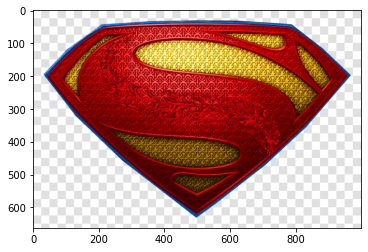

[[255 255 255]
 [255 255 255]
 [255 255 255]
 ...
 [224 224 224]
 [224 224 224]
 [224 224 224]]


In [34]:
target = cv2.imread("./assets/demo/superman/bat_sup_logo.png", cv2.IMREAD_UNCHANGED)
scene = cv2.imread("./assets/demo/superman/scene_1.png")
source = cv2.imread("./assets/demo/superman/superman_logo.png", cv2.IMREAD_UNCHANGED)
#add_alpha_channel(source)
plt.figure()
plt.imshow(source[:,:,::-1])
plt.show()
print(target[0,:])
#ble = blend(estimator, target, scene, source)

In [ ]:
from tqdm import tqdm
scene_path = './assets/demo/poster.MOV'
target_path = './assets/demo/target_movie.jpg'
source_path = './assets/demo/source_movie.mp4'
save_path = './assets/demo/out_movie.avi'
print('reading scene')
scenes, _ = read_video(scene_path)
print('reading source')
sources, fps = read_video(source_path)
plt.figure()
plt.imshow(scenes[0][:,:,::-1])
target = cv2.imread(target_path)
imgs = []
for i, scene in tqdm(enumerate(scenes), total = len(scenes)):
    source = sources[i%len(sources)]
    imgs.append(blend(estimator, target, scene, source))
save_video(imgs, fps=fps, size=(imgs[0].shape[1], imgs[0].shape[0]), video_path=save_path)